<a href="https://colab.research.google.com/github/kroush/Thinkful-Capstones/blob/main/Capstone_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Estimation of the Critical Temperatures of Superconductors Using Extracted Features from Known Superconductors

###Kaleb Roush

A superconductor is a material that has the ability to transmit electricity, i.e. maintain a current through it, without any resistance. This means that means an electric current can flow without any energy loss. However, this phenomenon only occurs at or below a certain temperature - the critical temperature ($T_c$) - for each material which is often a cryogenic temperature very close to absolute zero (0 Kelvin or -273.1$^{\circ}$C).[[1]](https://en.wikipedia.org/wiki/Superconductivity)

Superconductors have wide spread applications today and hold great promise for future technological advancement. Superconducting magnets are among the most powerful magnets developed today, as the sheer amount of resistance-free current that can be flowed through them is so high. These types of magnets are used in MRI machines, particle accelerators, and currently in the development of fusion reactors. Developing better superconductors holds a lot of promise, especially in the energy sector with regard to powerlines and the global effort to produce power via fusion.[1]

The datasets here contains information about 21,263 known superconductors. 80 features are derived from their chemical formula plus the critical temperature, as shown in the charts below and their chemical formulas broken up element-wise into different columns. The goal of this analysis is to generate a model that can predict the critical temperature of a semiconductor from its features. The dataset is available publically on the UCI Machine Learning Repository and was used initially in a paper published in Computational Materials Science.[[2]](https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data/)[[3]](https://oadoi.org/10.1016/j.commatsci.2018.07.052)

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1xB_LNPSDYLuYKTzNlloahimKnIVFRCs7/preview" width="600" height="250"></iframe>
<iframe src="https://drive.google.com/file/d/1VotiPtE0iasGd36JIvYADWwE3_OUvl3a/preview" width="640" height="380"></iframe>

## Set Up and Import Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.model_selection import cross_val_score
#import torch
!pip3 install ax-platform
from ax import optimize
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')
from IPython.display import clear_output
clear_output()

In [ ]:
PATH = '/content/drive/My Drive/Thinkful/Data/superconductor_train.csv'  #derived features
super_df1 = pd.read_csv(PATH)

PATH = '/content/drive/My Drive/Thinkful/Data/superconductor_unique_m.csv'  #superconductors broken down elementwise
super_df2 = pd.read_csv(PATH)

In [ ]:
display(super_df1.info())
super_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 88 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   H              21263 non-null  float64
 1   He             21263 non-null  int64  
 2   Li             21263 non-null  float64
 3   Be             21263 non-null  float64
 4   B              21263 non-null  float64
 5   C              21263 non-null  float64
 6   N              21263 non-null  float64
 7   O              21263 non-null  float64
 8   F              21263 non-null  float64
 9   Ne             21263 non-null  int64  
 10  Na             21263 non-null  float64
 11  Mg             21263 non-null  float64
 12  Al             21263 non-null  float64
 13  Si             21263 non-null  float64
 14  P              21263 non-null  float64
 15  S              21263 non-null  float64
 16  Cl             21263 non-null  float64
 17  Ar             21263 non-null  int64  
 18  K     

While the cited paper only used the derived features, here the two tables will be combined for analysis to see if any elements on their own can help derive the $T_c$. There are no null values to deal with and the two tables can be joined into one.

In [ ]:
super_df2.drop(columns='critical_temp', inplace=True)    #drop repeat column between two datasets

In [ ]:
super_full = pd.concat([super_df1, super_df2], axis=1)

In [ ]:
super_full.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,...,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,material
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,53.622535,775.425,1010.268571,718.152900,938.016780,1.305967,0.791488,810.6,735.985714,323.811808,355.562967,160.25,105.514286,136.126003,84.528423,1.259244,1.207040,205,42.914286,75.237540,69.235569,4654.35725,2961.502286,724.953211,53.543811,1.033129,0.814598,8958.571,1579.583429,3306.162897,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.20,1.80,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.2La1.8Cu1O4
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,53.979870,766.440,1010.612857,720.605511,938.745413,1.544145,0.807078,810.6,743.164286,290.183029,354.963511,161.20,104.971429,141.465215,84.370167,1.508328,1.204115,205,50.571429,67.321319,68.008817,5821.48580,3021.016571,1237.095080,54.095718,1.314442,0.914802,10488.571,1667.383429,3767.403176,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.10,1.90,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.1La1.9Ag0.1Cu0.9O4
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,53.656268,775.425,1010.820000,718.152900,939.009036,1.305967,0.773620,810.6,743.164286,323.811808,354.804183,160.25,104.685714,136.126003,84.214573,1.259244,1.132547,205,49.314286,75.237540,67.797712,4654.35725,2999.159429,724.953211,53.974022,1.033129,0.760305,8958.571,1667.383429,3306.162897,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.10,1.90,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.1La1.9Cu1O4
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,53.639405,775.425,1010.544286,718.152900,938.512777,1.305967,0.783207,810.6,739.575000,323.811808,355.183884,160.25,105.100000,136.126003,84.371352,1.259244,1.173033,205,46.114286,75.237540,68.521665,4654.35725,2980.330857,724.953211,53.758486,1.033129,0.788889,8958.571,1623.483429,3306.162897,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.15,1.85,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.15La1.85Cu1O4
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,53.588771,775.425,1009.717143,718.152900,937.025573,1.305967,0.805230,810.6,728.807143,323.811808,356.319281,160.25,106.342857,136.126003,84.843442,1.259244,1.261194,205,36.514286,75.237540,70.634448,4654.35725,2923.845143,724.953211,53.117029,1.033129,0.859811,8958.571,1491.783429,3306.162897,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.30,1.70,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.3La1.7Cu1O4


##Data Exploration and Feature Selection

###Distributions of Derived Features

Here's looking for anything that might be off or weird in the data. We'll exclude the elemental data as it won't provide any value in a histogram. Based on the following, it looks like we are ready to push forward toward data selection. There is an element of trust going into the use of this data set.

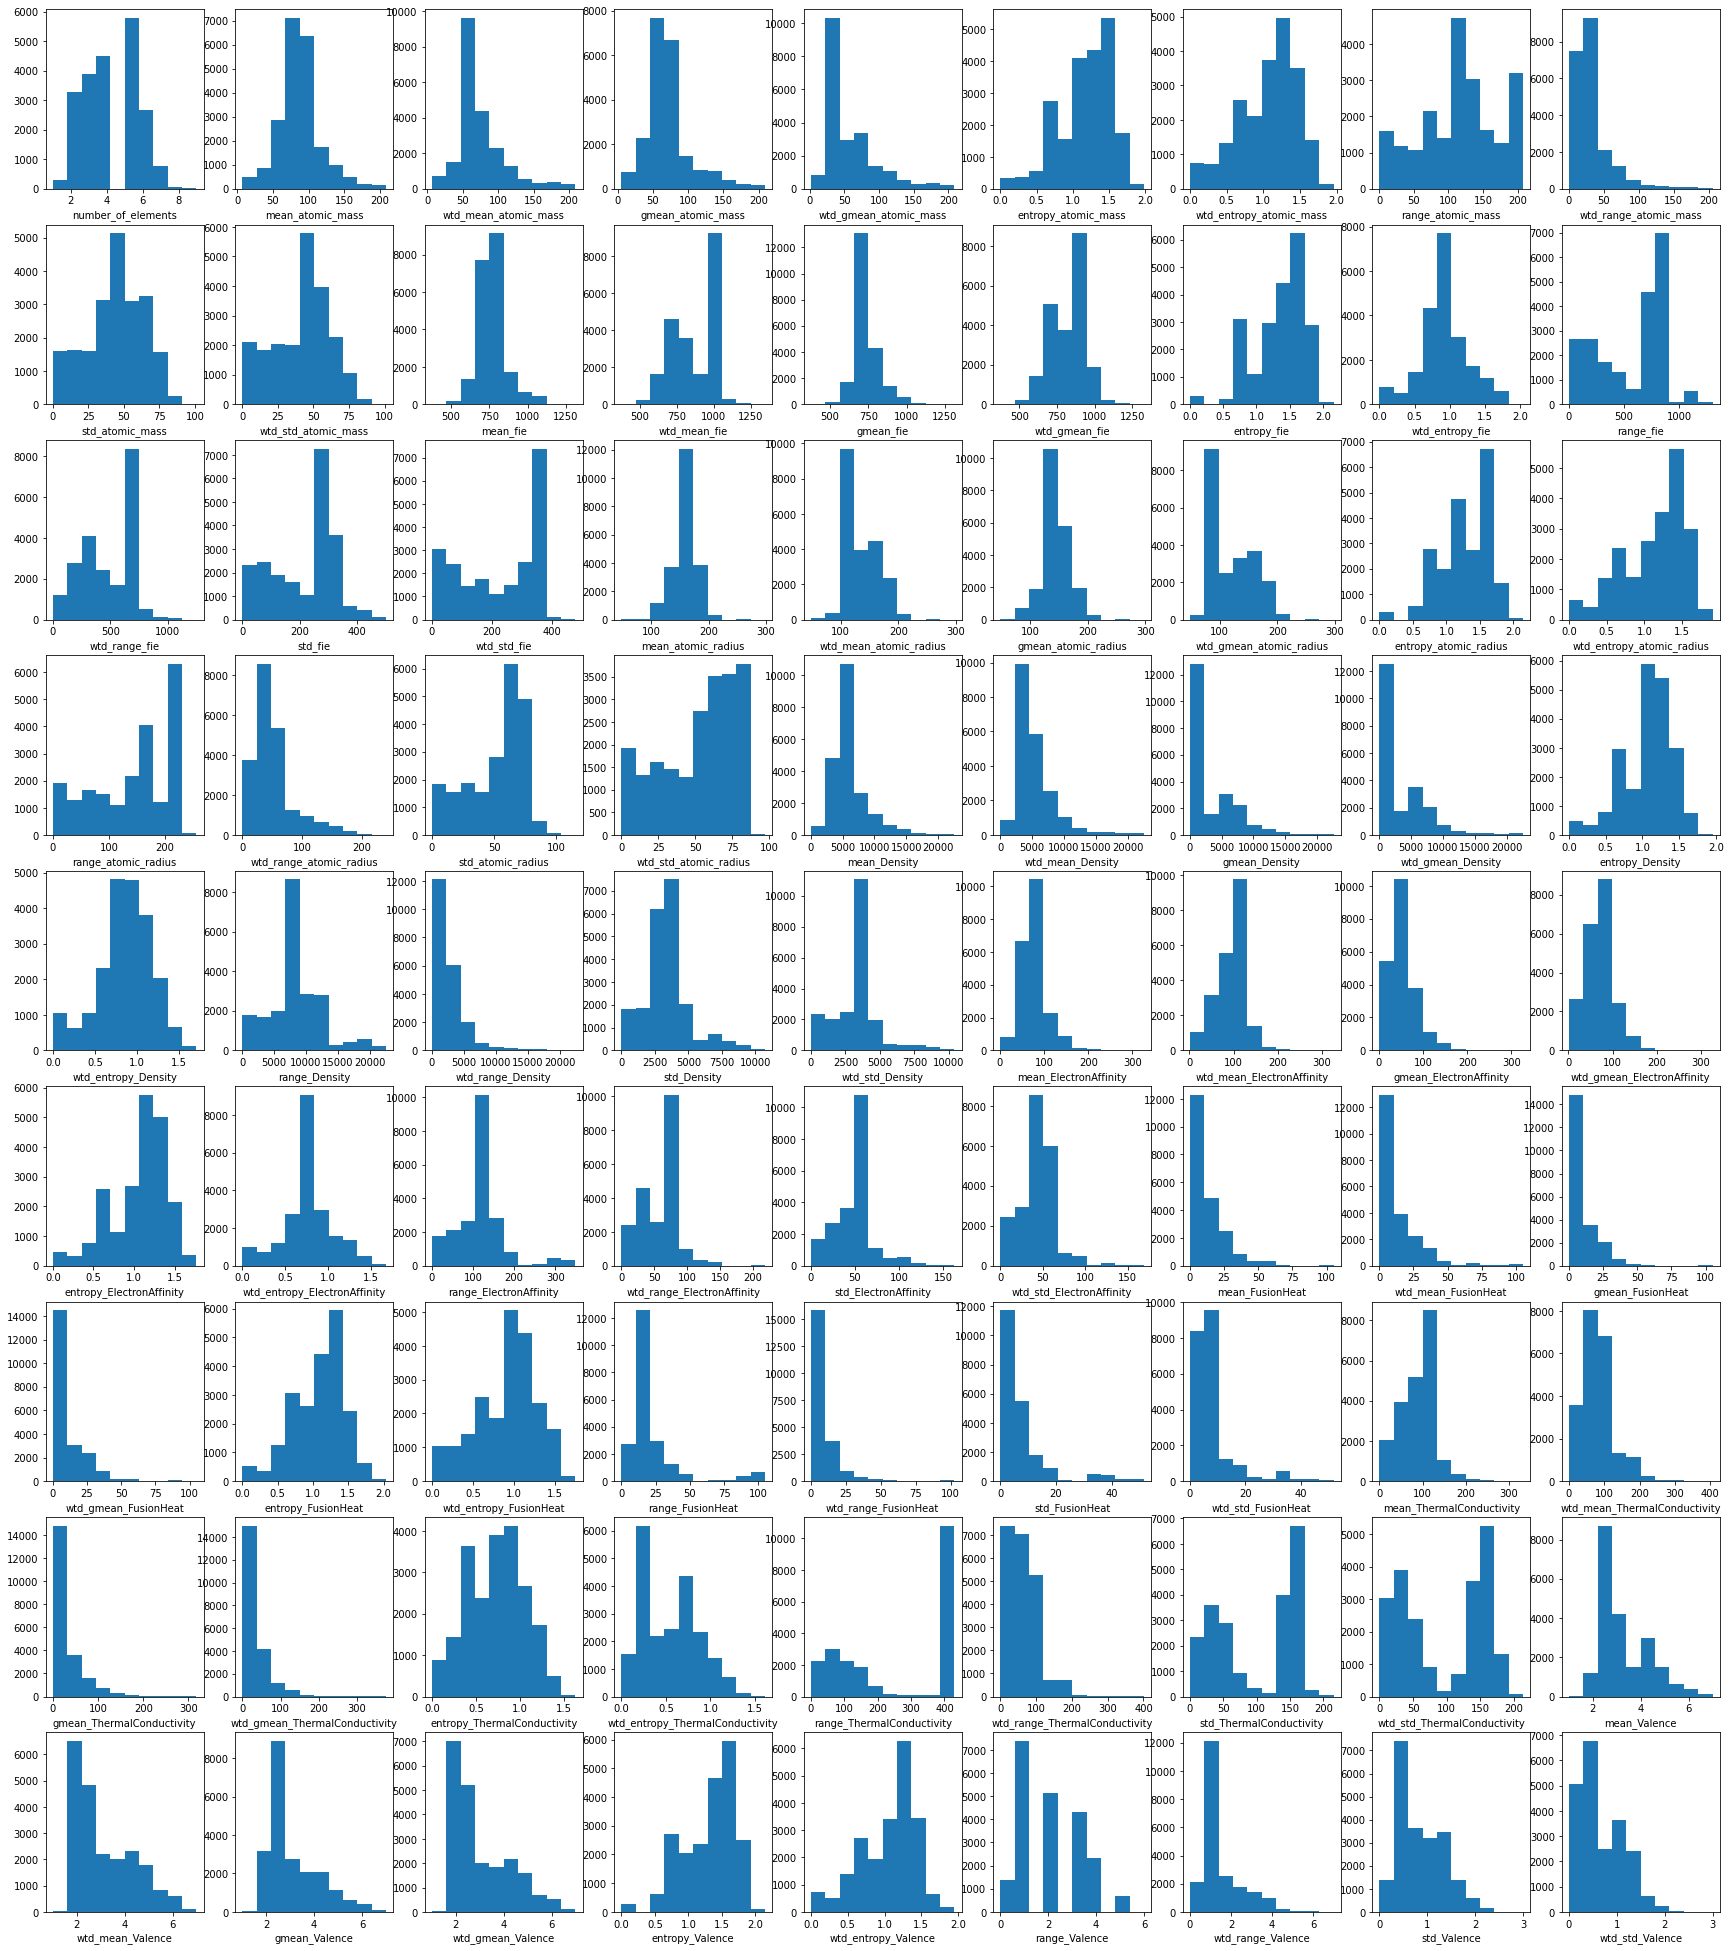

In [ ]:
columns = super_full.columns.to_list()

plt.figure(figsize=(30,35))

for i, col in enumerate(columns[0:81], start=1):
  plt.subplot(9,9,i)
  plt.xlabel(col)
  plt.hist(super_full[col])
plt.show()

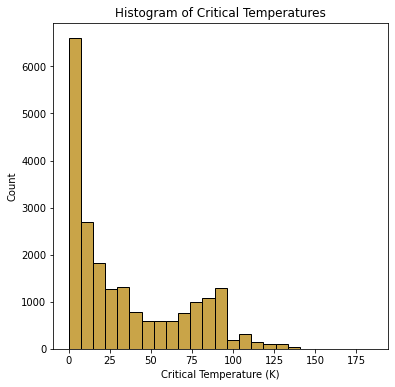

In [ ]:
plt.figure(figsize=[6,6])
plt.title('Histogram of Critical Temperatures')
plt.xlabel('Critical Temperature (K)')
plt.ylabel('Count')
sns.histplot(data=super_full, x='critical_temp', bins=25, color='darkgoldenrod')
plt.show()

Let's take a look at the number of instances of each material - which will be accomplished by summing booleans of it's values from the super_df2 DataFrame. That is, even if a material contains 3 coppers, for example, it will only be counted 1 time in the following. There may be a correlation only for elements that are more widespread. This would beg the question to further be explored wether or not to exclude the elements altogether as all the elements' properties sould be reflected in the variables in super_df1.

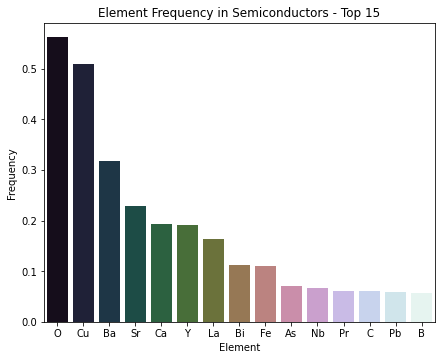

In [ ]:
pd.set_option('display.max_rows', None)
element_count = pd.DataFrame(super_df2.astype(bool).sum(axis=0).sort_values(ascending=False))
element_count = element_count.reset_index().rename(columns={0:'count', 'index':'Element'})
element_count['Frequency'] = element_count['count']/len(super_full.index)
element_count = element_count[1:16]
element_count

plt.figure(figsize=[7,5.5])
plt.title('Element Frequency in Semiconductors - Top 15')
sns.barplot(x='Element', y='Frequency', data=element_count, palette='cubehelix')
plt.show()

###Feature Selection - Correlations

To properly gauge the significance of a feature's correlation with the critical temperature, the absolute value of the correlation number will be used.

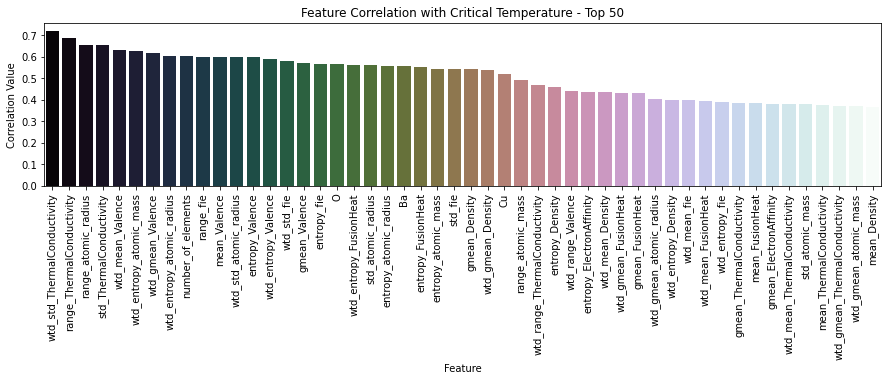

In [ ]:
correlations = np.abs(super_full[super_full.columns].corr()[['critical_temp']]).sort_values(by='critical_temp', ascending=False)
#display(correlations)
correlations = correlations.reset_index().rename(columns={'critical_temp':'Correlation Value', 'index':'Feature'})
correlations = correlations[1:51]

plt.figure(figsize=[15,3])
plt.title('Feature Correlation with Critical Temperature - Top 50')
sns.barplot(x='Feature', y='Correlation Value', data=correlations, palette='cubehelix')
plt.xticks(rotation=90)
plt.show()

The correlations values are spread all over the place and we are seeing O, Cu, Ba, Sr etc. appearing with higher correlation values likely as a result of their widespread presence. It's time to check for cross correlations anyway, so we'll see if they make the cut going forward.

We'll begin look as the correlations within each variable. We'll start collecting a list of features, looking for ones that correlate with $T_c$ at 0.35 or higher and don't correlate with other variables at 0.7 or lower.

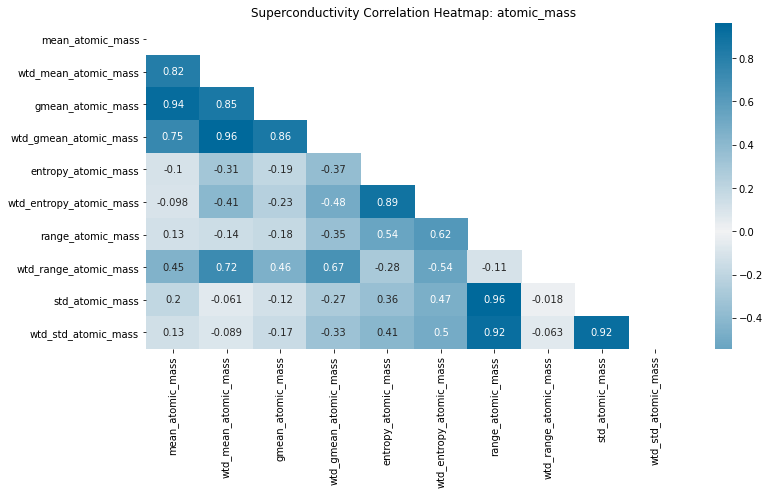

,critical_temp
wtd_entropy_atomic_mass,0.626930
entropy_atomic_mass,0.543619
range_atomic_mass,0.491970
std_atomic_mass,0.378766
wtd_gmean_atomic_mass,0.369858
wtd_std_atomic_mass,0.359306
wtd_range_atomic_mass,0.337131
wtd_mean_atomic_mass,0.312272
gmean_atomic_mass,0.230345
mean_atomic_mass,0.113523


In [ ]:
def superconductor_feature_select (variable):
  feature_corr = (super_full[super_full.filter(like=variable).columns].corr())
  mask = np.zeros_like(feature_corr)
  mask[np.triu_indices_from(mask)] = True

  plt.figure(figsize=(12,6))
  sns.heatmap(feature_corr, annot=True, mask=mask, cmap=sns.diverging_palette(241, 241, s=100, l=42, n=20, as_cmap=True), center=0)
  plt.title(f'Superconductivity Correlation Heatmap: {variable}', y = 1.08)
  plt.show()

  pd.set_option('max_rows', None)

  correlations = np.abs(super_full[super_full.columns].corr()[['critical_temp']]).filter(like=variable, axis=0).sort_values(by='critical_temp', ascending=False)
  display(correlations)

  pd.set_option('max_rows', 20)

superconductor_feature_select('atomic_mass')

In [ ]:
model_features = ['wtd_entropy_atomic_mass', 'range_atomic_mass']

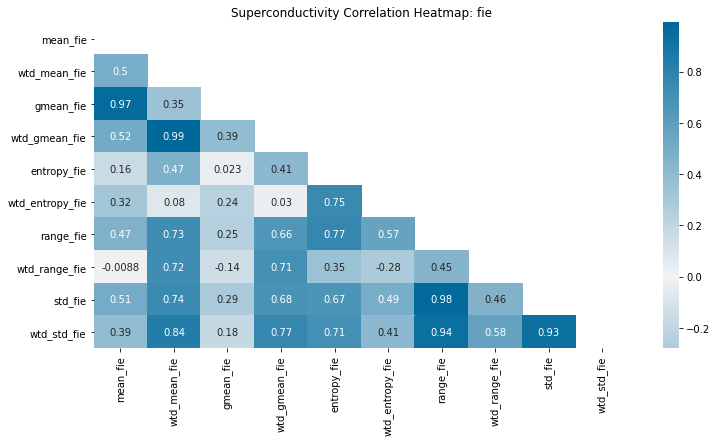

,critical_temp
range_fie,0.600790
wtd_std_fie,0.582013
entropy_fie,0.567817
std_fie,0.541804
wtd_mean_fie,0.398796
wtd_entropy_fie,0.388359
wtd_gmean_fie,0.343747
wtd_range_fie,0.300482
mean_fie,0.102268
gmean_fie,0.025103


In [ ]:
superconductor_feature_select('fie')

In [ ]:
model_features += ['range_fie', 'wtd_entropy_fie']

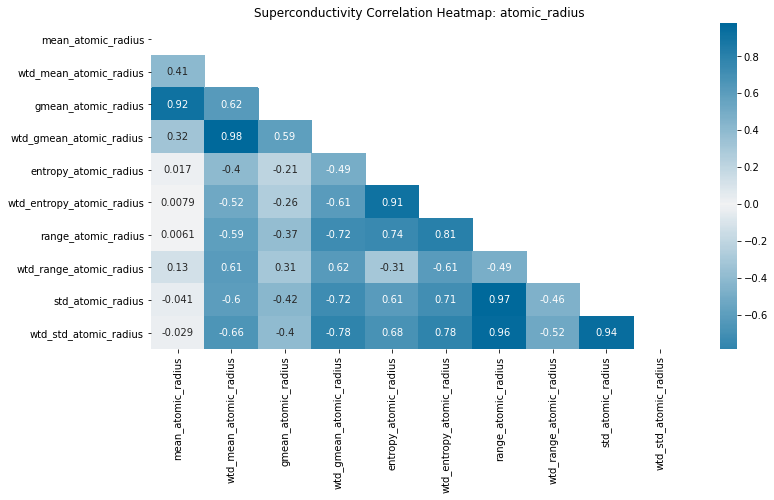

,critical_temp
range_atomic_radius,0.653759
wtd_entropy_atomic_radius,0.603494
wtd_std_atomic_radius,0.599199
std_atomic_radius,0.559629
entropy_atomic_radius,0.558937
wtd_gmean_atomic_radius,0.405176
wtd_range_atomic_radius,0.344100
wtd_mean_atomic_radius,0.297272
gmean_atomic_radius,0.143770
mean_atomic_radius,0.105273


In [ ]:
superconductor_feature_select('atomic_radius')

In [ ]:
model_features += ['range_atomic_radius']

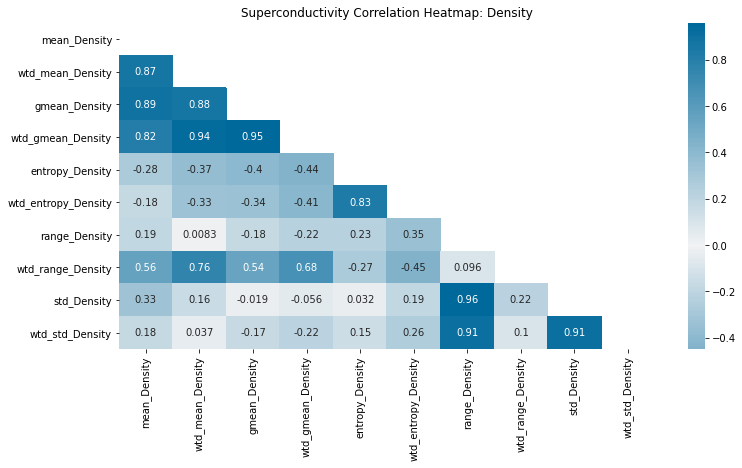

,critical_temp
gmean_Density,0.541684
wtd_gmean_Density,0.540046
entropy_Density,0.457169
wtd_mean_Density,0.433940
wtd_entropy_Density,0.400190
mean_Density,0.368262
wtd_range_Density,0.284729
range_Density,0.260536
wtd_std_Density,0.207663
std_Density,0.115243


In [ ]:
superconductor_feature_select('Density')

In [ ]:
model_features += ['gmean_Density', 'entropy_Density']

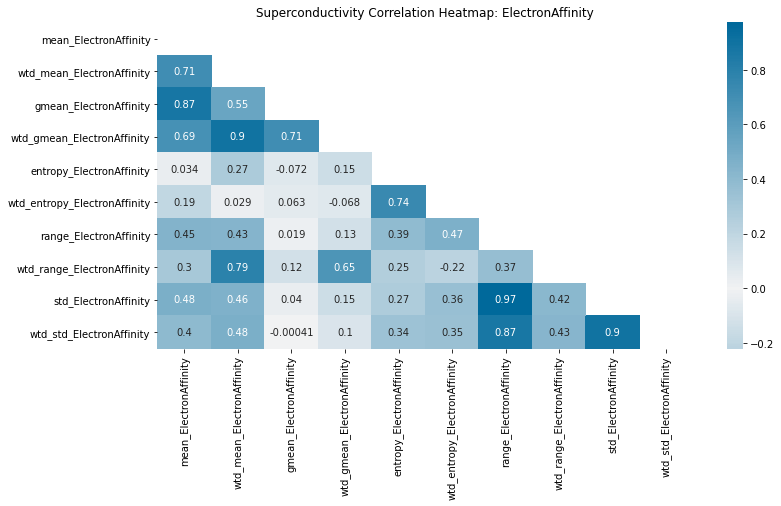

,critical_temp
entropy_ElectronAffinity,0.437207
gmean_ElectronAffinity,0.380568
wtd_std_ElectronAffinity,0.315147
range_ElectronAffinity,0.279705
std_ElectronAffinity,0.262103
wtd_entropy_ElectronAffinity,0.237648
mean_ElectronAffinity,0.193550
wtd_range_ElectronAffinity,0.185348
wtd_mean_ElectronAffinity,0.111516
wtd_gmean_ElectronAffinity,0.107359


In [ ]:
superconductor_feature_select('ElectronAffinity')

In [ ]:
model_features += ['entropy_ElectronAffinity', 'gmean_ElectronAffinity']

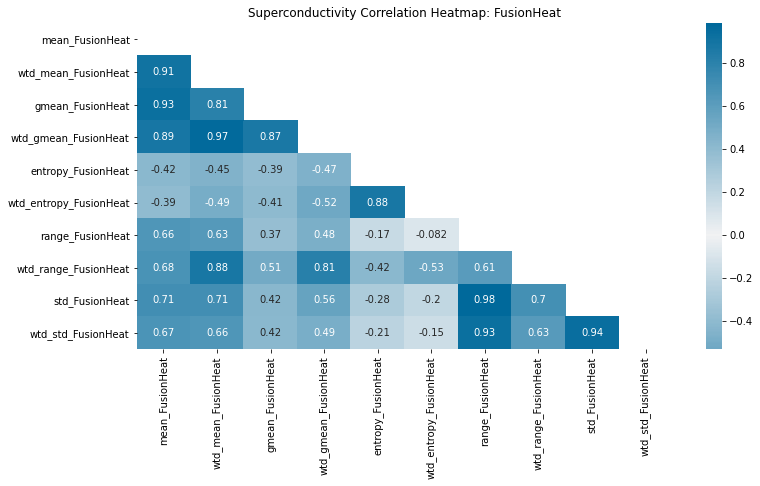

,critical_temp
wtd_entropy_FusionHeat,0.563244
entropy_FusionHeat,0.552709
wtd_gmean_FusionHeat,0.432365
gmean_FusionHeat,0.431795
wtd_mean_FusionHeat,0.394117
mean_FusionHeat,0.385509
wtd_range_FusionHeat,0.314178
std_FusionHeat,0.201310
wtd_std_FusionHeat,0.195571
range_FusionHeat,0.140714


In [ ]:
superconductor_feature_select('FusionHeat')

In [ ]:
model_features += ['wtd_entropy_FusionHeat']

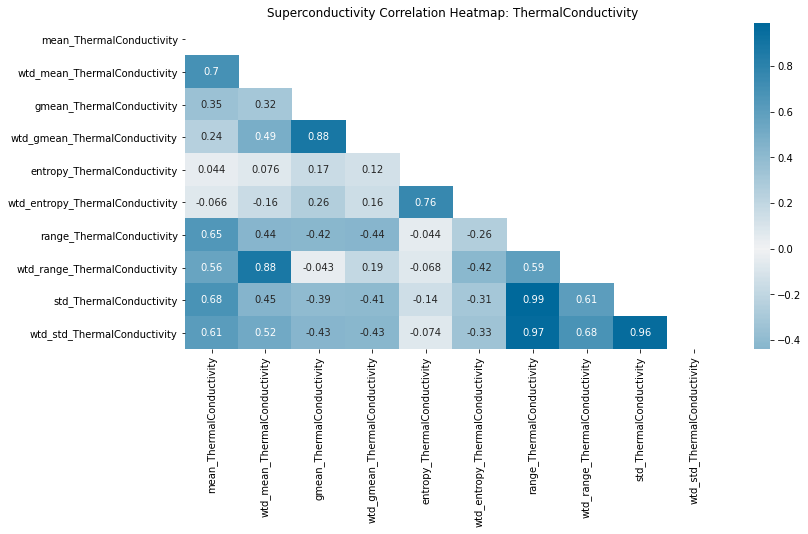

,critical_temp
wtd_std_ThermalConductivity,0.721271
range_ThermalConductivity,0.687654
std_ThermalConductivity,0.653632
wtd_range_ThermalConductivity,0.469572
gmean_ThermalConductivity,0.387192
wtd_mean_ThermalConductivity,0.379336
mean_ThermalConductivity,0.375813
wtd_gmean_ThermalConductivity,0.371601
wtd_entropy_ThermalConductivity,0.116728
entropy_ThermalConductivity,0.085862


In [ ]:
superconductor_feature_select('ThermalConductivity')

In [ ]:
model_features += ['wtd_std_ThermalConductivity', 'range_ThermalConductivity']

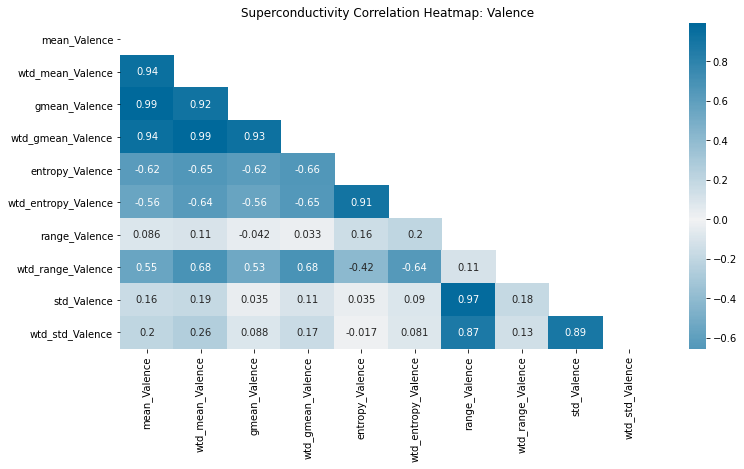

,critical_temp
wtd_mean_Valence,0.632401
wtd_gmean_Valence,0.615653
mean_Valence,0.600085
entropy_Valence,0.598591
wtd_entropy_Valence,0.589664
gmean_Valence,0.573068
wtd_range_Valence,0.439901
wtd_std_Valence,0.300028
std_Valence,0.208072
range_Valence,0.143546


In [ ]:
superconductor_feature_select('Valence')

In [ ]:
model_features += ['wtd_mean_Valence']

The 'model_features' list is a list of features that are all highly correlated (generally 0.4 or higher) with $T_c$ and are not well correlated with other variables in the same class. Let's look at their correlations with each other and the elements that correlations above 0.5 with $T_c$.

In [ ]:
model_features += ['O', 'Ba', 'Cu']
model_features

['wtd_entropy_atomic_mass',
 'range_atomic_mass',
 'range_fie',
 'wtd_entropy_fie',
 'range_atomic_radius',
 'gmean_Density',
 'entropy_Density',
 'entropy_ElectronAffinity',
 'gmean_ElectronAffinity',
 'wtd_entropy_FusionHeat',
 'wtd_std_ThermalConductivity',
 'range_ThermalConductivity',
 'wtd_mean_Valence',
 'O',
 'Ba',
 'Cu']

####Selected Features 

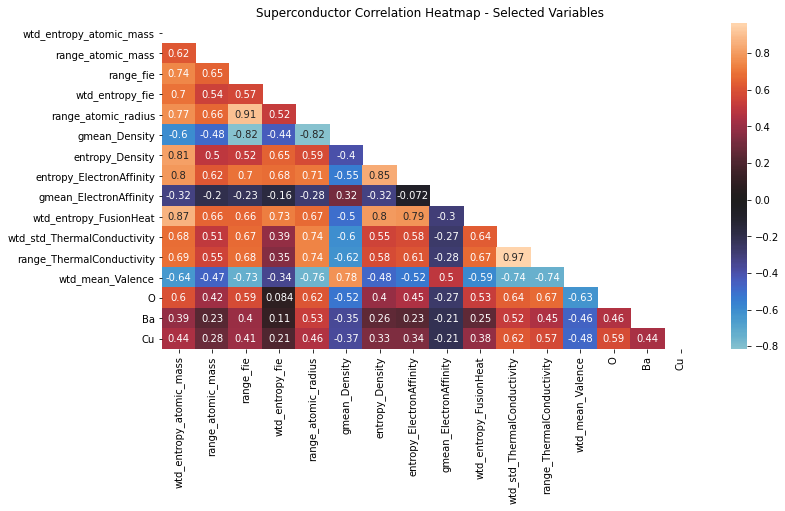

In [ ]:
feature_corr = (super_full[super_full[model_features].columns].corr())
mask = np.zeros_like(feature_corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,6))
sns.heatmap(feature_corr, annot=True, mask=mask, center=0)
plt.title('Superconductor Correlation Heatmap - Selected Variables')
plt.show()

From here, we'll eliminate variables that correlate strongly with each other. We'll start with a 0.8 threshold and favor the feature that most strongly correlates with the $T_c$.

*   Range_fie will be dropped in favor of range_atomic_radius (0.91)
* gmean_density will be dropped in favor of range_atomic_radius (0.82)
*   Entropy_density will be dropped in favor of wtd_entropy_atomic_mass (0.81), as will wt_entropy_fusion_heat be dropped (0.87)
*  Wtd_std_ThermalConductivity will be kept over range_ThermalConductivity (0.97)



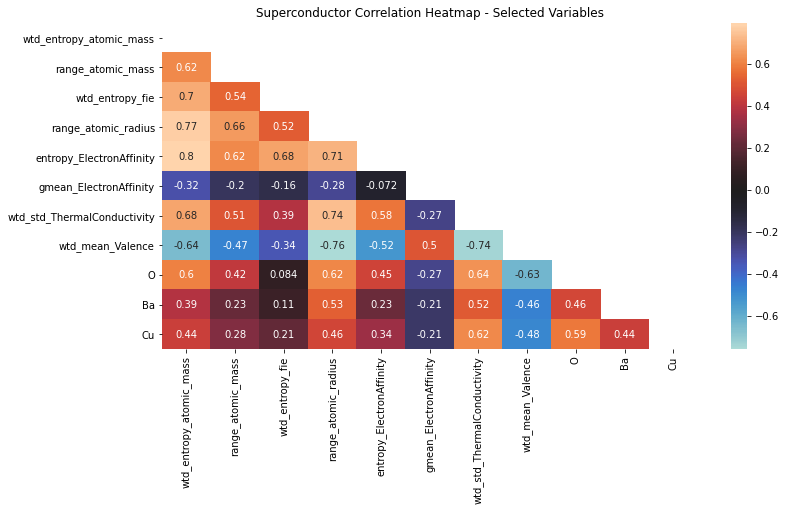

In [ ]:
model_features = ['wtd_entropy_atomic_mass',
 'range_atomic_mass',
 'wtd_entropy_fie',
 'range_atomic_radius',
 'entropy_ElectronAffinity',
 'gmean_ElectronAffinity',
 'wtd_std_ThermalConductivity',
 'wtd_mean_Valence',
 'O',
 'Ba',
 'Cu']

feature_corr = (super_full[super_full[model_features].columns].corr())
mask = np.zeros_like(feature_corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,6))
sns.heatmap(feature_corr, annot=True, mask=mask, center=0)
plt.title('Superconductor Correlation Heatmap - Selected Variables')
plt.show()

We do still have some highly correlated variables here. We'll continue with our model creation methods and see if any other modifications will make sense going forward. We'll start with Random Forest that can offer some great insight into feature selection as well.

##Supervised Models


####Preprocessing
Let's set up our model test and training sets. We'll create normalized and standardized test and training sets. For each model, we'll build off of these stated sets.

In [ ]:
from sklearn.preprocessing import normalize, scale, StandardScaler

In [ ]:
X = super_full[model_features]
Y = super_full['critical_temp']

X_normal = pd.DataFrame(normalize(X, axis=0, norm='max'), columns=model_features)
Y_normal = pd.DataFrame(normalize(np.array(Y).reshape(1,-1), norm='max').reshape(-1,1), columns=['critical_temp'])
X_stndz = pd.DataFrame(scale(X), columns=model_features)
Y_stndz = pd.DataFrame(scale(np.array(Y)), columns=['critical_temp'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=47)
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(X_normal, Y_normal, test_size=.3, random_state=47)
X_train_stndz, X_test_stndz, y_train_stndz, y_test_stndz = train_test_split(X_stndz, Y_stndz, test_size=.3, random_state=47)

###Random Forest

Below you'll see standardized and normal data used for Random Forest. Through trial and error I found no difference between normal and unaltered X's. Using standardized or normalized Y didn't appear to impact the performance of each model either, so I left it as is to make it easily comparable to the cited paper and for ease of understanding. Standardized data did have a significant effect, often making models fairly useless in certain cases.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

R square of training set: 0.9772761545321843
_____________________Test Stats_____________________
R square of test in the model: 0.9186354276629664
MAE: 5.477982795336765
MSE: 96.5849082698945
RMSE: 9.827762119114123
MAPE: 434.98391042243026


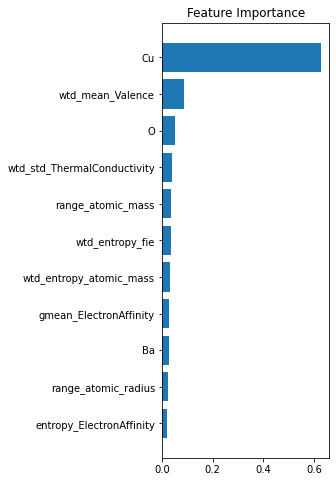

In [ ]:
X = super_full[model_features]
Y = super_full['critical_temp']

rfr = RandomForestRegressor(n_estimators=100, random_state=47)
rfr.fit(X_train_stndz, y_train)
y_pred = rfr.predict(X_test_stndz)

print('R square of training set:', rfr.score(X_train_stndz, y_train))
print('_____________________Test Stats_____________________')
print('R square of test in the model:', rfr.score(X_test_stndz, y_test))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mse(y_test, y_pred))
print('RMSE:', rmse(y_test, y_pred))
print('MAPE:', np.mean(np.abs((y_test - y_pred) / y_test)) * 100)

sorted_index = rfr.feature_importances_.argsort()
x_cols = X.columns
plt.figure(figsize=(3,8))
plt.title('Feature Importance')
plt.barh(x_cols[sorted_index], rfr.feature_importances_[sorted_index])
plt.show()

####Hyperparameter selection

Here I performed hyperparameter selection using Ax's optimizer function. It takes small steps with each trial and records how change an hyperparameter effects your target function, which in all models is some sort of test statistic like the mean of the scores of cross validation, RMSE, etc. I did this for every model.

In [ ]:
#this cell take a while to run, don't rerun unless necessary
#def rfr_optimize(p):
#  rfr = RandomForestRegressor(**p)
#  score = cross_val_score(rfr, X_normal, Y, cv=3, scoring='neg_root_mean_squared_error')
#  return score.std()

#best_parameters, best_values, _, _ = optimize(
#    parameters=[
#          {'name':'n_estimators', 'type': 'choice','values': [100,150,125,175,200]},
#          {'name':'min_samples_leaf', 'type':'range', 'bounds': [1,10]},
#          #{'name':'bootstrap', 'type':'fixed', 'value': [True]}, #have run several times not nedded
#          #{'name':'criterion', 'type':'fixed', 'value': ['mse']}, #have run several times not needed#          {'name':'random_state', 'type':'fixed', 'value': 47},
#          {'name':'min_samples_split', 'type':'range', 'bounds': [2,10]}], evaluation_function=rfr_optimize, minimize=True)

#display(best_parameters)
#display(best_values)

In [ ]:
start_time = datetime.now()

rfr = RandomForestRegressor(n_estimators=150, criterion='mse', min_samples_leaf=1, min_samples_split=5, random_state=47)
rfr.fit(X_train_normal, y_train)
y_pred = rfr.predict(X_test_normal)

end_time = datetime.now()
rfr_runtime = end_time - start_time

print('R square of training set:', rfr.score(X_train_normal, y_train))
rfr_r_train = rfr.score(X_train_normal, y_train)
rfr_r_test = rfr.score(X_test_normal, y_test)
RandomForestRMSE = rmse(y_test, y_pred)
print('_____________________Test Stats_____________________')
print('R square of test in the model:', rfr.score(X_test_normal, y_test))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mse(y_test, y_pred))
print('RMSE:', rmse(y_test, y_pred))
print('MAPE:', np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
print('Runtime:', rfr_runtime)

R square of training set: 0.9732000087504702
_____________________Test Stats_____________________
R square of test in the model: 0.9190389114761768
MAE: 5.512691117107699
MSE: 96.10594739087831
RMSE: 9.803364085398355
MAPE: 431.2068414985793
Runtime: 0:00:13.331816


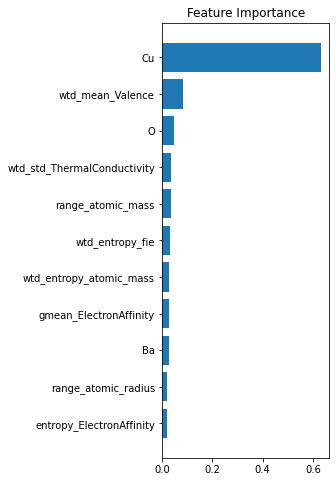

In [ ]:
sorted_index = rfr.feature_importances_.argsort()
x_cols = X.columns
plt.figure(figsize=(3,8))
plt.title('Feature Importance')
plt.barh(x_cols[sorted_index], rfr.feature_importances_[sorted_index])
plt.show()

In [ ]:
cvs = cross_val_score(rfr, X_normal, Y, cv=5)
display(cvs)
rfr_cvs_mean = cvs.mean()
rfr_cvs_95CI = cvs.std()*2
print("Cross Val R2: %0.2f (+/- %0.2f)" % (rfr_cvs_mean, rfr_cvs_95CI))

cvs = cross_val_score(rfr, X_normal, Y, cv=5, scoring='neg_root_mean_squared_error')
display(cvs)
rfr_rmse_mean = cvs.mean()*-1
rfr_rmse_95CI = cvs.std()*2
print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (rfr_rmse_mean, rfr_rmse_95CI))

array([0.66297626, 0.69177204, 0.88443385, 0.79328233, 0.60279963])

Cross Val R2: 0.73 (+/- 0.20)


array([-17.93635742, -17.01071384, -10.08877374,  -4.9426053 ,
       -14.60926328])

Cross Val Accuracy: 12.92 (+/- 9.65)


###Linear Regression

Standardized data removed to much variance needed in Linear Regression (and other models). Unscaled or normalized data performs much better. 

In [ ]:
X_trainlrm = sm.add_constant(X_train_normal)
X_testlrm = sm.add_constant(X_test_normal)

results = sm.OLS(y_train, X_trainlrm, hasconst=True).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          critical_temp   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     2327.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        04:56:57   Log-Likelihood:                -66228.
No. Observations:               14884   AIC:                         1.325e+05
Df Residuals:                   14872   BIC:                         1.326e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.1964      1.317      0.908      0.364      -1.386       3.778
wtd_entropy_atomic_mass        20.2268      2.056      9.836      0.000      16.196      24.258
range_atomic_mass              13.7592      0.936     14.699      0.000      11.924      15.594
wtd_entropy_fie                30.7551      1.939     15.859      0.000      26.954      34.556
range_atomic_radius             7.3270      1.442      5.082      0.000       4.501      10.153
entropy_ElectronAffinity      -35.6965      1.706    -20.921      0.000     -39.041     -32.352
gmean_ElectronAffinity        -41.7660      2.427    -17.206      0.000     -46.524     -37.008
wtd_std_ThermalConductivity    43.7410      1.051     41.608      0.000      41.680      45.802
wtd_mean_Valence               -3.4658      1.945     -1.782      0.075      -7.278       0.346
O                              55.3528      5.174     10.698      0.000      45.211      65.495
Ba                            162.4850      5.165     31.460      0.000     152.361     172.609
Cu                             34.8824      9.952      3.505      0.000      15.374      54.390
==============================================================================
Omnibus:                      529.772   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1425.777
Skew:                          -0.126   Prob(JB):                    2.49e-310
Kurtosis:                       4.495   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X_trainlrm = X_trainlrm.drop(columns=['wtd_mean_Valence', 'const'])
X_testlrm = X_testlrm.drop(columns=['wtd_mean_Valence', 'const'])

results = sm.OLS(y_train, X_trainlrm, hasconst=False).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          critical_temp   R-squared (uncentered):                   0.816
Model:                            OLS   Adj. R-squared (uncentered):              0.816
Method:                 Least Squares   F-statistic:                              6612.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                        0.00
Time:                        04:56:57   Log-Likelihood:                         -66230.
No. Observations:               14884   AIC:                                  1.325e+05
Df Residuals:                   14874   BIC:                                  1.326e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
wtd_entropy_atomic_mass        19.6234      2.011      9.759      0.000      15.682      23.565
range_atomic_mass              13.5106      0.929     14.551      0.000      11.691      15.331
wtd_entropy_fie                30.3728      1.926     15.772      0.000      26.598      34.148
range_atomic_radius             8.2762      1.335      6.198      0.000       5.659      10.894
entropy_ElectronAffinity      -35.6798      1.691    -21.100      0.000     -38.994     -32.365
gmean_ElectronAffinity        -45.1381      1.750    -25.798      0.000     -48.568     -41.709
wtd_std_ThermalConductivity    44.4289      0.984     45.133      0.000      42.499      46.358
O                              56.7043      5.133     11.047      0.000      46.643      66.765
Ba                            161.9375      5.158     31.394      0.000     151.827     172.048
Cu                             34.7584      9.948      3.494      0.000      15.258      54.258
==============================================================================
Omnibus:                      536.098   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1464.223
Skew:                          -0.122   Prob(JB):                         0.00
Kurtosis:                       4.517   Cond. No.                         83.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
y_pred_lrm = results.predict(X_testlrm)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lrm))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lrm))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lrm)))

Mean Absolute Error: 15.492122650396366
Mean Squared Error: 403.5037092198812
Root Mean Squared Error: 20.087401753832705


Our RMSE value is currently almost double that of the Random Forest. One of the assumptions of linear regression models is low multicollinearity and it does look like that might be an issue here. Let's see if we can continue to widdle down the features we're using and still maintain a high R-squared value and lower the RMSE. It also may just not be the best model for this data set.

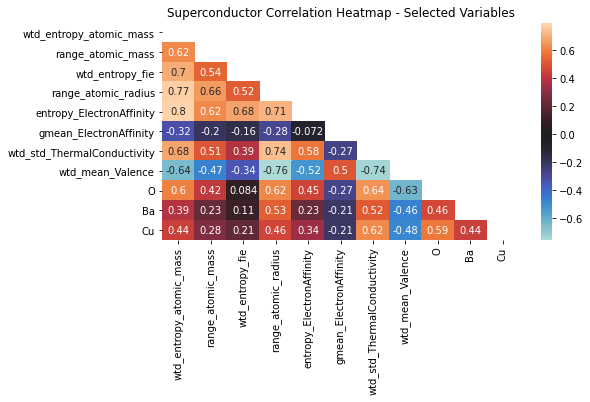

In [ ]:
feature_corr = (X_normal[X_normal[model_features].columns].corr())
plt.figure(figsize=(8,4))
sns.heatmap(feature_corr, annot=True, mask=mask, center=0)
plt.title('Superconductor Correlation Heatmap - Selected Variables')
plt.show()

We'll keep those most correlated with the target and drop those correlated with them at 0.6 or higher.

In [ ]:
LinearRegressionFeatures = ['wtd_std_ThermalConductivity',
 'wtd_entropy_fie',
 'range_atomic_mass',
 'gmean_ElectronAffinity',
 'Ba']

X_trainlrm_filtered = X_trainlrm[LinearRegressionFeatures]

X_testlrm_filtered = X_testlrm[LinearRegressionFeatures]

results = sm.OLS(y_train, X_trainlrm_filtered, hasconst=False).fit()
display(results.summary())

y_pred_lrm = results.predict(X_testlrm_filtered)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lrm))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lrm))
LinearRegressionRMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lrm))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lrm)))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          critical_temp   R-squared (uncentered):                   0.808
Model:                            OLS   Adj. R-squared (uncentered):              0.808
Method:                 Least Squares   F-statistic:                          1.250e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                        0.00
Time:                        04:56:57   Log-Likelihood:                         -66573.
No. Observations:               14884   AIC:                                  1.332e+05
Df Residuals:                   14879   BIC:                                  1.332e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
wtd_std_ThermalConductivity    51.6959      0.774     66.790      0.000      50.179      53.213
wtd_entropy_fie                19.1657      1.107     17.318      0.000      16.996      21.335
range_atomic_mass              15.0724      0.837     18.011      0.000      13.432      16.713
gmean_ElectronAffinity        -65.0381      1.548    -42.023      0.000     -68.072     -62.004
Ba                            198.4446      4.829     41.091      0.000     188.978     207.911
==============================================================================
Omnibus:                      659.641   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2279.118
Skew:                          -0.022   Prob(JB):                         0.00
Kurtosis:                       4.917   Cond. No.                         25.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mean Absolute Error: 15.854840481317762
Mean Squared Error: 426.25350468881635
Root Mean Squared Error: 20.64590769835069


In [ ]:
start_time = datetime.now()

lrm = LinearRegression(fit_intercept=False)  #this should repeat above so we can caluclate a cross_val_score
lrm.fit(X_trainlrm_filtered, y_train)

end_time = datetime.now()
lrm_runtime = end_time - start_time

y_preds_train = lrm.predict(X_trainlrm_filtered)
y_pred_test = lrm.predict(X_testlrm_filtered)

print('R square of training set:', lrm.score(X_trainlrm_filtered, y_train))
print('_____________________Test Stats_____________________')
lrm_r_train = lrm.score(X_trainlrm_filtered, y_train)
lrm_r_test = lrm.score(X_testlrm_filtered, y_test)
print('R square of test in the model:', lrm.score(X_testlrm_filtered, y_test))
print('MAE:', mean_absolute_error(y_test, y_pred_test))
print('MSE:', mse(y_test, y_pred_test))
print('RMSE:', rmse(y_test, y_pred_test))
print('MAPE:', np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100)

X_all = pd.concat([X_trainlrm_filtered, X_testlrm_filtered])
Y_all = pd.concat([y_train, y_test])

cvs_lrm = cross_val_score(lrm, X_all, Y_all, cv=5)
lrm_cvs_mean = cvs_lrm.mean()
lrm_cvs_95CI = cvs_lrm.std()*2
print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (cvs_lrm.mean(), cvs_lrm.std()*2))

cvs_lrm = cross_val_score(lrm, X_all, Y_all, cv=5, scoring='neg_root_mean_squared_error')
lrm_rmse_mean = cvs_lrm.mean()*-1
lrm_rmse_95CI = cvs_lrm.std()*2
print("Cross Val RSME: %0.2f (+/- %0.2f)" % (lrm_rmse_mean, cvs_lrm.std()*2))

R square of training set: 0.6150562933116368
_____________________Test Stats_____________________
R square of test in the model: 0.6409176678073454
MAE: 15.854840481317762
MSE: 426.25350468881635
RMSE: 20.64590769835069
MAPE: 3223.228119843854
Cross Val Accuracy: 0.62 (+/- 0.04)
Cross Val RSME: 21.06 (+/- 1.39)


Our errors all stayed almost the same , but it does look like the co-linearity problem when away if there was one that was effecting this model. The F statistic also increase, but the AIC and BIC increased a little as well. However, I think this is a better linear regression model.

 Let's check some of the assumptions of linear regression as well. The model we're using assumed linearity. The average of the error term should be zero.

In [ ]:
errors = y_test - y_pred_lrm
print('Mean of errors:', np.mean(errors))

Mean of errors: 0.5902438731214983


That's not as close to zero as we'd like to see, but this is only a small portion of the data. Next we'll check the homoscedasticity of the error terms.

In [ ]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(y_pred_lrm, errors)
lev_stats = levene(y_pred_lrm, errors)

print("Bartlett test statistic value is {0:.3f} and p value is {1:.3f}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:.3f} and p value is {1:.3f}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 392.991 and p value is 0.000
Levene test statistic value is 1279.650 and p value is 0.000


Another assumption is that the error terms are not correlated.

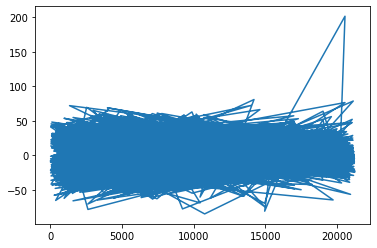

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



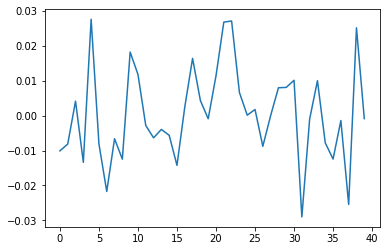

In [ ]:
plt.plot(errors)
plt.show()

from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

With correlation terms close to zero, our errors are uncorrelated. The last assumption is that the errors need to be normally distributed for the coefficients to hold any significance.

In [ ]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0:.3g} and p value is {1:.3f}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0:.3g} and p value is {1:.3f}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 989 and p value is 0.000
Normality test statistics is 356 and p value is 0.000


####Lasso, Ridge, ElasticNet
These are not normally distributed, so our coefficients can't tell us anything.
Let's check Lasso, Ridge, and Elastic Net Regress to ensure that we're as optimized as possible. 

In [ ]:
alpha_list = [10.0**x for x in np.arange(-20, 40, 1)]

lasso_cv = LassoCV(alphas=alpha_list, fit_intercept=False, cv=5, max_iter=1000000, tol=.01)

lasso_cv.fit(X_trainlrm_filtered, y_train)

y_preds_train = lasso_cv.predict(X_trainlrm_filtered)
y_preds_test = lasso_cv.predict(X_testlrm_filtered)
clear_output()
print('LASSO')
print('R square of training set:', lasso_cv.score(X_trainlrm_filtered, y_train))
print('Best alpha:', lasso_cv.alpha_)
print('_____________________Test Stats_____________________')
print('R square of test in the model:', lasso_cv.score(X_testlrm_filtered, y_test))
print('MAE:', mean_absolute_error(y_test, y_pred_test))
print('MSE:', mse(y_test, y_pred_test))
print('RMSE:', rmse(y_test, y_pred_test))
print('MAPE:', np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100)

LASSO
R square of training set: 0.6150555840084507
Best alpha: 0.001
_____________________Test Stats_____________________
R square of test in the model: 0.6408536362672106
MAE: 15.854840481317762
MSE: 426.25350468881635
RMSE: 20.64590769835069
MAPE: 3223.228119843854


In [ ]:
ridge_cv = RidgeCV(alphas=alpha_list, fit_intercept=False, cv=5)

ridge_cv.fit(X_trainlrm_filtered, y_train)

print('\nRIDGE')
y_preds_train = ridge_cv.predict(X_trainlrm_filtered)
y_preds_test = ridge_cv.predict(X_testlrm_filtered)
clear_output()
print('R square of training set:', ridge_cv.score(X_trainlrm_filtered, y_train))
print('Best alpha:', ridge_cv.alpha_)
print('_____________________Test Stats_____________________')
print('R square of test in the model:', ridge_cv.score(X_testlrm_filtered, y_test))
print('MAE:', mean_absolute_error(y_test, y_pred_test))
print('MSE:', mse(y_test, y_pred_test))
print('RMSE:', rmse(y_test, y_pred_test))
print('MAPE:', np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100)

R square of training set: 0.615055171906014
Best alpha: 0.1
_____________________Test Stats_____________________
R square of test in the model: 0.6408396361321991
MAE: 15.854840481317762
MSE: 426.25350468881635
RMSE: 20.64590769835069
MAPE: 3223.228119843854


In [ ]:
en_cv = ElasticNetCV(alphas=alpha_list, fit_intercept=False, cv=5)

en_cv.fit(X_trainlrm_filtered, y_train)

print('\nElasticNet')
y_preds_train = en_cv.predict(X_trainlrm_filtered)
y_preds_test = en_cv.predict(X_testlrm_filtered)
clear_output()
print('R square of training set:', en_cv.score(X_trainlrm_filtered, y_train))
print('Best alpha:', en_cv.alpha_)
print('_____________________Test Stats_____________________')
print('R square of test in the model:', en_cv.score(X_testlrm_filtered, y_test))
print('MAE:', mean_absolute_error(y_test, y_pred_test))
print('MSE:', mse(y_test, y_pred_test))
print('RMSE:', rmse(y_test, y_pred_test))
print('MAPE:', np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100)

R square of training set: 0.615055664222816
Best alpha: 1e-05
_____________________Test Stats_____________________
R square of test in the model: 0.6408593469980253
MAE: 15.854840481317762
MSE: 426.25350468881635
RMSE: 20.64590769835069
MAPE: 3223.228119843854


There is not difference between any of the linear regression models ran here. Sticking with the basic OLS will be more than adequate.

### KNN Regression

In [ ]:
from sklearn import neighbors

In [ ]:
knn = neighbors.KNeighborsRegressor()
knn.fit(X_train_normal, y_train)

y_preds_test = knn.predict(X_test_normal)

print('R square of training set:', knn.score(X_train_normal, y_train))
print('_____________________Test Stats_____________________')
knn_r_train = knn.score(X_train_normal, y_train)
knn_r_test = knn.score(X_test_normal, y_test)
print('R square of test in the model:', knn.score(X_test_normal, y_test))
print('MAE:', mean_absolute_error(y_test, y_preds_test))
print('MSE:', mse(y_test, y_preds_test))
print('RMSE:', rmse(y_test, y_preds_test))
print('MAPE:', np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100)

score = cross_val_score(knn, X, Y, cv=3)
print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()*2))

R square of training set: 0.9260316180668771
_____________________Test Stats_____________________
R square of test in the model: 0.8879648716828988
MAE: 6.49998487803731
MSE: 132.99280363313434
RMSE: 11.53225058837755
MAPE: 452.64783974119996
Cross Val Accuracy: 0.61 (+/- 0.30)


####Hyperparameter Selection

In [ ]:
#def knn_optimize(p):
#  knn = neighbors.KNeighborsRegressor(**p)
#  knn.fit(X_train_normal, y_train)
#  y_pred = knn.predict(X_test_normal)
#  #score = cross_val_score(knn, X_normal, Y, cv=5, scoring='neg_root_mean_squared_error')
#  return np.sqrt(metrics.mean_squared_error(y_test, y_pred))
#  #return score.std()

#best_parameters, best_values, _, _ = optimize(
#    parameters=[
#          {'name':'n_neighbors', 'type': 'range','bounds': [1,200]},
#          {'name':'weights', 'type':'choice', 'values': ['uniform', 'distance']},
#          {'name':'leaf_size', 'type':'range', 'bounds': [15,100]},
#          {'name':'p', 'type':'choice', 'values': [1,2]}], evaluation_function=knn_optimize, minimize=True, total_trials=25)#

#best_parameters, best_values

In [ ]:
start_time = datetime.now()

knn = neighbors.KNeighborsRegressor(n_neighbors=20, weights='distance', leaf_size=70, p=2)
knn.fit(X_train_normal, y_train)

stop_time = datetime.now()
knn_runtime = stop_time - start_time

y_preds_test = knn.predict(X_test_normal)

print('R square of training set:', knn.score(X_train_normal, y_train))
print('_____________________Test Stats_____________________')
print('R square of test in the model:', knn.score(X_test_normal, y_test))
print('MAE:', mean_absolute_error(y_test, y_preds_test))
print('MSE:', mse(y_test, y_preds_test))
print('RMSE:', rmse(y_test, y_preds_test))
print('MAPE:', np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100)

score = cross_val_score(knn, X, Y, cv=5)
print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()*2))

R square of training set: 0.98609559038244
_____________________Test Stats_____________________
R square of test in the model: 0.8902759104102357
MAE: 6.528421223618104
MSE: 130.2494540759904
RMSE: 11.412688293123159
MAPE: 466.80342755681784
Cross Val Accuracy: 0.65 (+/- 0.22)


In [ ]:
start_time = datetime.now()

knn = neighbors.KNeighborsRegressor(n_neighbors=162, weights='distance', leaf_size=17, p=1)
knn.fit(X_train_normal, y_train)

stop_time = datetime.now()
knn_runtime = stop_time - start_time

y_preds_test = knn.predict(X_test_normal)

print('R square of training set:', knn.score(X_train_normal, y_train))
print('_____________________Test Stats_____________________')

print('R square of test in the model:', knn.score(X_test_normal, y_test))
print('MAE:', mean_absolute_error(y_test, y_preds_test))
print('MSE:', mse(y_test, y_preds_test))
print('RMSE:', rmse(y_test, y_preds_test))
KNN_RMSE = rmse(y_test, y_preds_test)
print('MAPE:', np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100)

score = cross_val_score(knn, X, Y, cv=5)
knn_cvs_mean = score.mean()
knn_cvs_95CI = score.std()*2
print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()*2))

score = cross_val_score(knn, X, Y, cv=5, scoring='neg_root_mean_squared_error')
knn_rmse_mean = score.mean()*-1
knn_rmse_95CI = score.std()*2
print("Cross Val RMSE: %0.2f (+/- %0.2f)" % (knn_rmse_mean, score.std()*2))

R square of training set: 0.9861828360338356
_____________________Test Stats_____________________
R square of test in the model: 0.8666525202948381
MAE: 7.637574463214808
MSE: 158.29191656037935
RMSE: 12.581411548804027
MAPE: 581.7046925193935
Cross Val Accuracy: 0.66 (+/- 0.20)
Cross Val RMSE: 14.51 (+/- 10.59)


###SVM

In [ ]:
from sklearn.svm import SVR

In [ ]:
svr = SVR()
svr.fit(X_train_normal,y_train)

y_preds_test = svr.predict(X_test_normal)

print('R square of training set:', svr.score(X_train_normal, y_train))
print('_____________________Test Stats_____________________')

print('R square of test in the model:', svr.score(X_test_normal, y_test))
print('MAE:', mean_absolute_error(y_test, y_preds_test))
print('MSE:', mse(y_test, y_preds_test))
print('RMSE:', rmse(y_test, y_preds_test))
print('MAPE:', np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100)

score = cross_val_score(svr, X_normal, Y, cv=5)
print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()*2))

R square of training set: 0.7246494482707476
_____________________Test Stats_____________________
R square of test in the model: 0.7435638517484668
MAE: 12.027377135939856
MSE: 304.4059735650589
RMSE: 17.447233980349402
MAPE: 1358.0509823759098
Cross Val Accuracy: 0.48 (+/- 0.32)


####Hyperparameter Selection

In [ ]:
#def svr_optimize(p):
#  svr = SVR(**p)
 # svr.fit(X_train_normal, y_train)
#  y_pred = svr.predict(X_test_normal)
#  return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

#best_parameters, best_values, _, _ = optimize(
#    parameters=[
#          {'name':'kernel', 'type': 'choice','values': ['linear', 'poly', 'rbf', 'sigmoid']},
 #         {'name':'degree', 'type':'range', 'bounds': [1,10]},
 #         {'name':'gamma', 'type':'choice', 'values': ['scale', 'auto']}], evaluation_function=svr_optimize, minimize=True)

#best_parameters, best_values

This cell takes longer than 3 hours to run. The results of these 'optimized' parameters' are not signficantly different than what I discovered by removing 'poly' and therefore 'degree' as hyperparameters.

In [ ]:
#start_time = datetime.now()

#svr = SVR(kernel= 'poly', degree=10 , gamma='scale')
#svr.fit(X_train_normal,y_train)

#stop_time = datime.now()
#SVM1_runtime = stop_time - start_time

#y_preds_test = svr.predict(X_test_normal)
#
#print('R square of training set:', svr.score(X_train_normal, y_train))
#print('_____________________Test Stats_____________________')
#print('R square of test in the model:', svr.score(X_test_normal, y_test))
#print('MAE:', mean_absolute_error(y_test, y_preds_test))
#print('MSE:', mse(y_test, y_preds_test))
#print('RMSE:', rmse(y_test, y_preds_test))
#SVM1_RMSE = rmse(y_test, y_preds_test)
#print('MAPE:', np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100)

#score = cross_val_score(svr, X, Y, cv=5)
#SVM1_cvs_mean = score.mean()
#SVM1_cvs_95CI = score.std()*2
#print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()*2))


Let's try again but get rid of the poly and sigmoid kernel choices to see if a *simpler* kernel can be optimized better.

In [ ]:
#def svr_optimize(p):
#  svr = SVR(**p)
  #svr.fit(X_train_normal, y_train)
  #y_pred = svr.predict(X_test_normal)
#  score = cross_val_score(svr, X_normal, Y, cv=3)
#  return score.std()

#best_parameters, best_values, _, _ = optimize(
#    parameters=[
#          {'name':'kernel', 'type': 'choice','values': ['linear', 'rbf']},
#          #{'name':'degree', 'type':'range', 'bounds': [1,10]},
#          {'name':'gamma', 'type':'choice', 'values': ['scale', 'auto']},
#          {'name':'epsilon', 'type':'range', 'bounds': [0.01, 1.0]},
#          {'name':'C', 'type':'range', 'bounds': [40.0, 100.0]},
#          {'name':'shrinking', 'type':'choice', 'values': [True, False]}], evaluation_function=svr_optimize, minimize=True)

#best_parameters, best_values

In [ ]:
start_time = datetime.now()

svr = SVR(kernel= 'rbf', C=95, epsilon=0.971, gamma='scale', shrinking=False)
svr.fit(X_train_normal,y_train)

stop_time = datetime.now()
SVM2_runtime = stop_time - start_time

y_preds_test = svr.predict(X_test_normal)

print('R square of training set:', svr.score(X_train_normal, y_train))
print('_____________________Test Stats_____________________')
print('R square of test in the model:', svr.score(X_test_normal, y_test))
svr_r_train = svr.score(X_train_normal, y_train)
svr_r_test = svr.score(X_test_normal, y_test)
print('MAE:', mean_absolute_error(y_test, y_preds_test))
print('MSE:', mse(y_test, y_preds_test))
print('RMSE:', rmse(y_test, y_preds_test))
SVM2_RMSE = rmse(y_test, y_preds_test)
print('MAPE:', np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100)

score = cross_val_score(svr, X_normal, Y, cv=5)
SVM2_cvs_mean = score.mean()
SVM2_cvs_95CI = score.std()*2
print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()*2))

score = cross_val_score(svr, X_normal, Y, cv=5, scoring='neg_root_mean_squared_error')
SVM2_rmse_mean = score.mean()*-1
SVM2_rmse_95CI = score.std()*2
print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (SVM2_rmse_mean, score.std()*2))

R square of training set: 0.7709224031242262
_____________________Test Stats_____________________
R square of test in the model: 0.7847328340318698
MAE: 10.381761281858674
MSE: 255.53578027090032
RMSE: 15.985486550959289
MAPE: 1047.7657970563653
Cross Val Accuracy: 0.57 (+/- 0.26)
Cross Val Accuracy: 16.10 (+/- 11.90)


###Boosting Model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train_normal,y_train)

y_preds_test = gbr.predict(X_test_normal)

print('R square of training set:', gbr.score(X_train_normal, y_train))
print('_____________________Test Stats_____________________')
print('R square of test in the model:', gbr.score(X_test_normal, y_test))
print('MAE:', mean_absolute_error(y_test, y_preds_test))
print('MSE:', mse(y_test, y_preds_test))
print('RMSE:', rmse(y_test, y_preds_test))
print('MAPE:', np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100)

score = cross_val_score(gbr, X_normal, Y, cv=3)
print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()*2))

R square of training set: 0.8522306574281623
_____________________Test Stats_____________________
R square of test in the model: 0.8516961176148852
MAE: 9.12245371043271
MSE: 176.04611521710038
RMSE: 13.26823708022661
MAPE: 1120.6849102651468
Cross Val Accuracy: 0.69 (+/- 0.21)


####Hyperparameter Selection

In [ ]:
#def gbr_optimize(p):
#  gbr = GradientBoostingRegressor(**p)
#  #gbr.fit(X_train_normal, y_train)
#  #y_pred = gbr.predict(X_test_normal)
#  score = cross_val_score(gbr, X_normal, Y, cv=5)
#  x = score.std()
#  return x

#best_parameters, best_values, _, _ = optimize(
#    parameters=[
#          {'name':'loss', 'type': 'choice','values': ['ls', 'lad', 'huber', 'quantile']},
#          {'name':'learning_rate', 'type':'range', 'bounds': [0.1, 1.0]},
#          {'name':'n_estimators', 'type':'range', 'bounds': [10,100]},
#          {'name':'max_depth', 'type':'range', 'bounds': [5,10]},
#          {'name':'min_samples_split', 'type':'range', 'bounds': [2,20]}], evaluation_function=gbr_optimize, minimize=True)

#best_parameters, best_values

In [ ]:
start_time = datetime.now()

gbr = GradientBoostingRegressor(loss='ls', learning_rate=.143, n_estimators=79, max_depth=6, min_samples_split=2)
gbr.fit(X_train_normal,y_train)

stop_time = datetime.now()
gbr_runtime = stop_time - start_time

y_preds_test = gbr.predict(X_test_normal)

print('R square of training set:', gbr.score(X_train_normal, y_train))
print('_____________________Test Stats_____________________')
print('R square of test in the model:', gbr.score(X_test_normal, y_test))
gbr_r_train = gbr.score(X_train_normal, y_train)
gbr_r_test = gbr.score(X_test_normal, y_test)
print('MAE:', mean_absolute_error(y_test, y_preds_test))
print('MSE:', mse(y_test, y_preds_test))
gbr_rmse = rmse(y_test, y_preds_test)
print('RMSE:', rmse(y_test, y_preds_test))
print('MAPE:', np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100)

score = cross_val_score(gbr, X_normal, Y, cv=5)
gbr_cvs_mean = score.mean()
gbr_cvs_95CI = score.std()*2
print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()*2))

score = cross_val_score(gbr, X_normal, Y, cv=5, scoring='neg_root_mean_squared_error')
gbr_rmse_mean = score.mean()*-1
gbr_rmse_95CI = score.std()*2
print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (gbr_rmse_mean, score.std()*2))

R square of training set: 0.9378446228266559
_____________________Test Stats_____________________
R square of test in the model: 0.9037385631500167
MAE: 6.803421035643499
MSE: 114.26843134591269
RMSE: 10.689641310442212
MAPE: 870.0444125346296
Cross Val Accuracy: 0.71 (+/- 0.18)
Cross Val Accuracy: 13.23 (+/- 8.61)


##Summary

In [ ]:
print(f'Random Forest \n\tRMSE: %0.2f \n\tCross Val RMSE: %0.2f (+/- %0.2f) \n\tR\u00b2 train, test: %0.2f, %0.2f \n\tCross Val Accuracy: %0.2f (+/- %0.2f) \n\tRuntime:{rfr_runtime}' \
      % (RandomForestRMSE, rfr_rmse_mean, rfr_rmse_95CI, rfr_r_train, rfr_r_test, rfr_cvs_mean, rfr_cvs_95CI))
print('______________________________________________')
print(f'Linear Regression \n\tRMSE: %0.2f \n\tCross Val RMSE: %0.2f (+/- %0.2f) \n\tR\u00b2 train, test: %0.2f, %0.2f \n\tCross Val Accuracy: %0.2f (+/- %0.2f) \n\tRuntime:{lrm_runtime}' \
      % (LinearRegressionRMSE, lrm_rmse_mean, lrm_rmse_95CI, lrm_r_train, lrm_r_test, lrm_cvs_mean, lrm_cvs_95CI))
print('______________________________________________')
print(f'KNN \n\tRMSE: %0.2f \n\tCross Val RMSE: %0.2f (+/- %0.2f) \n\tR\u00b2 train, test: %0.2f, %0.2f \n\tCross Val Accuracy: %0.2f (+/- %0.2f) \n\tRuntime:{knn_runtime}' \
      % (KNN_RMSE, knn_rmse_mean, knn_rmse_95CI, knn_r_train, knn_r_test, knn_cvs_mean, knn_cvs_95CI))
print('______________________________________________')
print(f'SVM Regression \n\tRMSE: %0.2f \n\tCross Val RMSE: %0.2f (+/- %0.2f) \n\tR\u00b2 train, test: %0.2f, %0.2f \n\tCross Val Accuracy: %0.2f (+/- %0.2f) \n\tRuntime:{SVM2_runtime}' \
      % (SVM2_RMSE, SVM2_rmse_mean, SVM2_rmse_95CI, svr_r_train, svr_r_test, SVM2_cvs_mean, SVM2_cvs_95CI))
print('______________________________________________')
print(f'Gradient Boosting \n\tRMSE: %0.2f \n\tCross Val RMSE: %0.2f (+/- %0.2f) \n\tR\u00b2 train, test: %0.2f, %0.2f \n\tCross Val Accuracy: %0.2f (+/- %0.2f) \n\tRuntime:{gbr_runtime}' \
      % (gbr_rmse, gbr_rmse_mean, gbr_rmse_95CI, gbr_r_train, gbr_r_test, gbr_cvs_mean, gbr_cvs_95CI))

Random Forest 
	RMSE: 9.80 
	Cross Val RMSE: 12.92 (+/- 9.65) 
	R² train, test: 0.97, 0.92 
	Cross Val Accuracy: 0.73 (+/- 0.20) 
	Runtime:0:00:13.331816
______________________________________________
Linear Regression 
	RMSE: 20.65 
	Cross Val RMSE: 21.06 (+/- 1.39) 
	R² train, test: 0.62, 0.64 
	Cross Val Accuracy: 0.62 (+/- 0.04) 
	Runtime:0:00:00.005457
______________________________________________
KNN 
	RMSE: 12.58 
	Cross Val RMSE: 14.51 (+/- 10.59) 
	R² train, test: 0.93, 0.89 
	Cross Val Accuracy: 0.66 (+/- 0.20) 
	Runtime:0:00:00.034901
______________________________________________
SVM Regression 
	RMSE: 15.99 
	Cross Val RMSE: 16.10 (+/- 11.90) 
	R² train, test: 0.77, 0.78 
	Cross Val Accuracy: 0.57 (+/- 0.26) 
	Runtime:0:00:52.956457
______________________________________________
Gradient Boosting 
	RMSE: 10.69 
	Cross Val RMSE: 13.23 (+/- 8.61) 
	R² train, test: 0.94, 0.90 
	Cross Val Accuracy: 0.71 (+/- 0.18) 
	Runtime:0:00:05.238682


Random Forest and Gradient Boosting are near ties, using minimal computer power, 13 and 5 seconds, respectively, to run the models. The paper cited above generated a model resulting in $\pm9.5K$ based on RSME (it's also interesting to note that this value is an average of 25 folds and no confidence interval was reported). These two models come very close to meeting that published benchmark; Random Forest coming the closest at $\pm9.8K$ using the same statistic. However, I believe Gradient Boosting to be the better model, using less computer power and having narrower confidence intervals for it's cross validation accuracies and root mean squares. Let's take a look at actual vs. predicted values in the test set to see how this model fuctions and if any limitations exist.

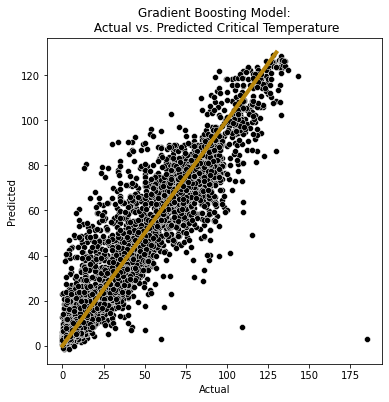

In [ ]:
plt.figure(figsize=[6,6])
sns.scatterplot(x=y_test, y=y_preds_test, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting Model:\n Actual vs. Predicted Critical Temperature')
plt.plot([0, 130], [0, 130], color = 'darkgoldenrod', linewidth='4')
plt.show()

Here, it's clear that this model appears to be more likely to overestimate the temperature at for lower temperature superconductors and to underestimate the temperature for higher ones. We can also see a few clear outliers, but in a test sample of about 6400 superconductors, these shouldn't skew our final statistics too significantly.